In [13]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

plt.style.use('ggplot')

In [14]:
# This function implements the KNN classifier
# This function computes the euclidean distance between data points
def euclidean_distance(x_s,y_s):
    # Iterates each element from both arrays, take its difference and power 2 before square root
    return np.sqrt(np.sum((x_s-y_s)**2))

# This function implements the Knn classifier
def knn(k, predicted_dp, pool):
    distances = [euclidean_distance(np.array([predicted_dp[0], predicted_dp[1]]),np.array([x, y])) for x, y, class_id in pool]
    vote_pool_indices = np.argsort(distances)[:k]
    vote_pool_classes = [pool[i][2] for i in vote_pool_indices]
    vote_result = Counter(vote_pool_classes).most_common()
    
    return vote_result[0][0]

In [15]:
df = pd.read_csv('hw5data.txt', sep= ' ', names= ['x','y', 'class'])

<Axes: ylabel='Frequency'>

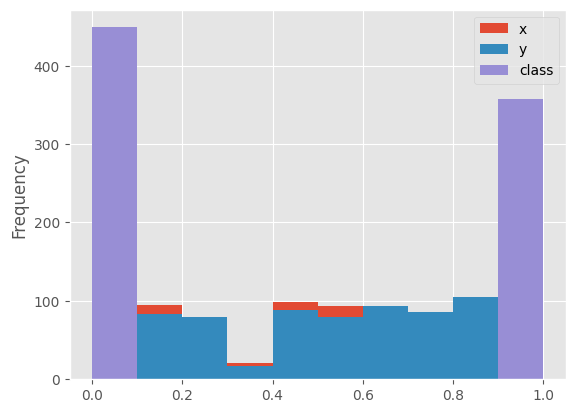

In [16]:
df.plot(kind= 'hist')

<Axes: xlabel='x', ylabel='y'>

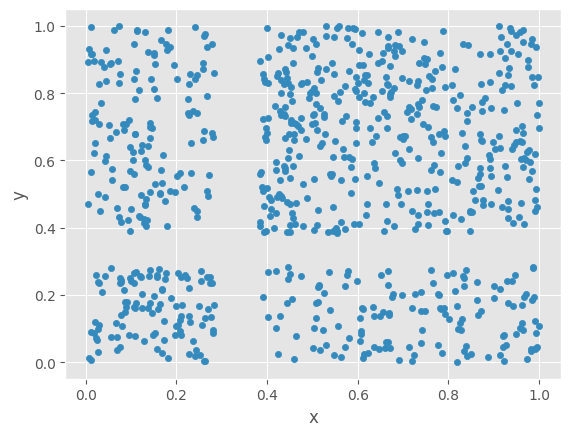

In [20]:
df.plot(x= 'x', y = 'y', kind= 'scatter')

In [11]:
# Create a dense 2D grid of data points 
mesh_X, mesh_Y = np.mgrid[0:8:10j,0:8:10j]

# Target classifier, g: It has a array P which is the classifier computed using all points in P (hw5data.txt). 

# Teaching/ student classifier, f: It has a array D which picks elements from P (hw5data.txt) D is a 
# subset or proper set of P, which holds the data points we want to include in teaching.

# We than use the dense grid to map it onto both the target classifier and teaching classifier. This generates
# feature vectors (x_{1}, x_{2}, y) with the same dimensions.

# Both feature vectors are fed into the disagreement function, which compares each dense grid points correspondingly
# by comparing their corresponding
# f(x') - computed from teaching classifier, and y' - computed from target classifiers which is defined in the disagreement function.
# Return the result of the unified cost function.

# Use that cost function result to do enumeration and greedy respectively. 

# Map the dense 2D grid to the target classifier, since we will be using it for all comparisons.

# Enumeration

# Define n
# Create a dataset enumeration function that takes in argument: n - size of teaching set
# Call the itertools.combination function, and find all combinations of list of n data points, which will form the teaching set.
# For each combination of teaching set, run KNN, and map the dense 2D grid; take both 2D grids into the disagreement function.
# Only keep the list of n data points with the least "cost" in the disagreement function.

# Greedy
# Randomly pick a data point to make the teaching set's size = 1.
# Iterate over each point in the pool, and store the data point that yields the smallest disagreement function value into the teaching set   
# Repeat until the teaching set, D reaches size n
